## Nnet-survival PDAC Transfer learning

Imports

In [136]:
import os
import keras.optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow.keras.backend as K
import nnet_survival
import keras_tuner as kt
import matplotlib.pylab as plt
import tensorflow as tf
import matplotlib.pylab as plt
import importlib

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from matplotlib.pyplot import figure
from tensorflow import keras
from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)
from matplotlib.pyplot import figure
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import load_model
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored,brier_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

### Import multi-cancer Data
<p> For every file in folder open read inside and store in pandas dataframe </p>

In [137]:
mrna_list = []
mrna_folder = "Data/mrnaDataUnscaled"
clinical_folder = "Data/ClinicalData"
for filename in sorted(os.listdir(mrna_folder)):
    f = os.path.join(mrna_folder, filename)
    print(f)
    data = pd.read_csv(f, sep=",")
    mrna_list.append(data)
    
clinical_list = []
for filename in sorted(os.listdir(clinical_folder)):
    f = os.path.join(clinical_folder, filename)
    data = pd.read_csv(f, sep="\t")
    clinical_list.append(data)

mrnaDataUnscaled/ACC.csv
mrnaDataUnscaled/BLCA.csv
mrnaDataUnscaled/BRCA.csv
mrnaDataUnscaled/CESC.csv
mrnaDataUnscaled/CHOL.csv
mrnaDataUnscaled/COAD.csv
mrnaDataUnscaled/DLBC.csv
mrnaDataUnscaled/ESCA.csv
mrnaDataUnscaled/GBM.csv
mrnaDataUnscaled/HNSC.csv
mrnaDataUnscaled/KICH.csv
mrnaDataUnscaled/KIRC.csv
mrnaDataUnscaled/KIRP.csv
mrnaDataUnscaled/LAML.csv
mrnaDataUnscaled/LGG.csv
mrnaDataUnscaled/LIHC.csv
mrnaDataUnscaled/LUAD.csv
mrnaDataUnscaled/LUSC.csv
mrnaDataUnscaled/MESO.csv
mrnaDataUnscaled/OV.csv
mrnaDataUnscaled/PCPG.csv
mrnaDataUnscaled/PRAD.csv
mrnaDataUnscaled/READ.csv
mrnaDataUnscaled/SARC.csv
mrnaDataUnscaled/SKCM.csv
mrnaDataUnscaled/STAD.csv
mrnaDataUnscaled/TGCT.csv
mrnaDataUnscaled/THCA.csv
mrnaDataUnscaled/THYM.csv
mrnaDataUnscaled/UCEC.csv
mrnaDataUnscaled/UCS.csv
mrnaDataUnscaled/UVM.csv


### Import optimal cancers subset

<p> These cancers are most similar to PDAC, and give the best performance.</p>
<ul>
  <li>STAD</li>
  <li>CHOL</li>
  <li>SARC</li>
  <li>TGCT</li>
    <li>COAD</li>
</ul>

In [ ]:
mrna_list = []
mrna_folder = "Data/subsetMrna"
clinical_folder = "Data/subsetClinical"
for filename in sorted(os.listdir(mrna_folder)):
    f = os.path.join(mrna_folder, filename)
    print(f)
    data = pd.read_csv(f, sep=",")
    mrna_list.append(data)
    
clinical_list = []
for filename in sorted(os.listdir(clinical_folder)):
    f = os.path.join(clinical_folder, filename)
    data = pd.read_csv(f, sep="\t")
    clinical_list.append(data)

### Prepare multi-cancer data for tensorflow 

<p>Every data set is handled individually, and merged in the end.<br></p>

<ol>
  <li>First The clinical samples are matched to the genomic samples.</li>
  <li>Then samples are filtered out of the clinical data that are not in the mRNA data</li>
  <li>After that all Not availables and Discrepancys are replaced with NaN.</li>
  <li>Vital status Dead and Alive are set to 1 and 0 respectively.</li>
  <li>Days are made numerical.</li>
  <li>Remove patients that have time 0 or NaN for time/status.</li>
  <li>Set Index of mRNA and clinical to patient barcode, and transpose the mRNA data so that the patients are in each row, and the genes in each column.</li>
</ol>

In [138]:
x_list = []
clinical_processed_list = []

for mrna,clinical in zip(mrna_list,clinical_list):
    mrna_id = mrna.columns[1:]

    # Match clinical samples to genomic samples
    clinical.columns = clinical.iloc[0]
    clinical = clinical.iloc[2:]

    # Make intersection of patient id's that are in mrna and clinicaldata
    clinical_id = clinical['bcr_patient_barcode']
    intersection = list(set(mrna_id) & set(clinical_id))
    intersection.sort()
    intersection = pd.Series(intersection)


    # Filter out samples in clinicaldata that are not in mrna
    a = clinical['bcr_patient_barcode'].isin(intersection)
    clinical = clinical[a]



    # Create clinicaldata dataframe with the important features
    clinicalnew = clinical[['bcr_patient_barcode',
                                "vital_status",
                                "days_to_last_followup",
                                "days_to_death"]]
    
    #print(clinicalnew['vital_status'].value_counts())
    

    # Set missing data to NaN
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Discrepancy]", 0)
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Not Available]",np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Applicable]", np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Available]", np.nan)
    clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Not Available]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)
    clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Completed]", np.nan)

    # In vital_status set dead = 1 alive = 0
    clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("Dead", 1)
    clinicalnew["vital_status"] = clinicalnew['vital_status'].replace("Alive", 0)

    # Set days to numeric values
    clinicalnew["days_to_last_followup"] = pd.to_numeric(clinicalnew["days_to_last_followup"])
    clinicalnew["days_to_death"] = pd.to_numeric(clinicalnew["days_to_death"])

    # Combine days to death and days to last follow up to create a total time.
    clinicalnew['time'] = clinicalnew['days_to_death'].combine_first(clinicalnew['days_to_last_followup'])

    # Remove patients that have time 0 (so no follow up, just one recording)
    clinicalnew = clinicalnew[clinicalnew.time != 0]

    #Remove patients with nan for time or status
    clinicalnew = clinicalnew.dropna(subset=['time'])
    clinicalnew = clinicalnew.dropna(subset=['vital_status'])
    
    #Remove patients where time is negative
    clinicalnew = clinicalnew[clinicalnew.time >= 0]

    mrna.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'}, inplace=True)
    mrna = mrna.set_index('bcr_patient_barcode')

    mrna = mrna.transpose()
    mrna = mrna[mrna.index.isin(clinicalnew['bcr_patient_barcode'])]
    mrna = mrna.reindex(np.random.RandomState(seed=1).permutation(mrna.index))
    
    clinicalnew = clinicalnew.set_index('bcr_patient_barcode')
    clinicalnew = clinicalnew.loc[~clinicalnew.index.duplicated(), :]
    clinicalnew = clinicalnew.reindex(index=mrna.index)
    
    x_list.append(mrna)
    clinical_processed_list.append(clinicalnew)


In [139]:
xf = pd.concat(x_list)
xf = xf.dropna(axis=1)
clinicalf = pd.concat(clinical_processed_list)

### PDAC data preparation

<p> Same steps as above </p>

In [140]:
clinicaldata = pd.read_csv(f"Data/TargetDataUnscaled/nationwidechildrens.org_clinical_patient_paad.txt", sep='\t')
mrna = pd.read_csv(f"Data/TargetDataUnscaled/PAAD.csv", sep=',')

In [141]:
mrna_id = mrna.columns[1:].tolist()

# Match clinical samples to genomic samples

clinicaldata.columns = clinicaldata.iloc[0]
clinicaldata = clinicaldata.iloc[2:]


# Make intersection of patient id's that are in mrna and clinicaldata
clinical_id = clinicaldata['bcr_patient_barcode']
intersection = list(set(mrna_id) & set(clinical_id))
intersection.sort()
intersection = pd.Series(intersection)


# Filter out samples in clinicaldata that are not in mrna
a = clinicaldata['bcr_patient_barcode'].isin(intersection)
clinicaldata = clinicaldata[a]


# Create clinicaldata dataframe with the important features
clinicalnew = clinicaldata[['bcr_patient_barcode',
                            "vital_status",
                            "days_to_last_followup",
                            "days_to_death"]]



# Set missing data to NaN
clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("[Discrepancy]", 0)
clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Applicable]", np.nan)
clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Not Available]", np.nan)
clinicalnew["days_to_death"] = clinicalnew['days_to_death'].replace("[Discrepancy]", np.nan)
clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Not Available]", np.nan)
clinicalnew['days_to_last_followup'] = clinicalnew['days_to_last_followup'].replace("[Discrepancy]", np.nan)

# In vital_status set dead = 1 alive = 0
clinicalnew['vital_status'] = clinicalnew['vital_status'].replace("Dead", 1)
clinicalnew["vital_status"] = clinicalnew['vital_status'].replace("Alive", 0)

# Set days to numeric values
clinicalnew["days_to_last_followup"] = pd.to_numeric(clinicalnew["days_to_last_followup"])
clinicalnew["days_to_death"] = pd.to_numeric(clinicalnew["days_to_death"])

# Combine days to death and days to last follow up to create a total time.
clinicalnew['time'] = clinicalnew['days_to_death'].combine_first(clinicalnew['days_to_last_followup'])

# Remove patients that have time 0 (so no follow up, just one recording)
clinicalnew = clinicalnew[clinicalnew.time != 0]

#Remove patients with nan for time
clinicalnew = clinicalnew.dropna(subset=['time'])

mrna.rename(columns={'Unnamed: 0': 'bcr_patient_barcode'}, inplace=True)
mrna = mrna.set_index('bcr_patient_barcode')

mrna = mrna.transpose()
mrna = mrna[mrna.index.isin(clinicalnew['bcr_patient_barcode'])]
mrna = mrna.reindex(np.random.RandomState(seed=1).permutation(mrna.index))
clinicalnew = clinicalnew.set_index('bcr_patient_barcode')
clinicalnew = clinicalnew.reindex(index=mrna.index)

In [142]:
xt = mrna
yt = clinicalnew

### ICGC Data
<p> Similar steps to above </p>

In [143]:
clinicaldata = pd.read_csv(f"Data/ICGCDataUnscaled/PDAC_ICGC_clinical.csv", sep=',')
mrna = pd.read_csv(f"Data/ICGCDataUnscaled/PDAC_ICGC.csv", sep=',')

In [144]:
# Create clinicaldata dataframe with the important features
clinicalnew = clinicaldata[['icgc_donor_id',
                            "donor_vital_status",
                            "donor_survival_time"]]



# Set missing data to NaN
clinicalnew['donor_vital_status'] = clinicalnew['donor_vital_status'].replace("", np.nan)

# In vital_status set dead = 1 alive = 0
clinicalnew['donor_vital_status'] = clinicalnew['donor_vital_status'].replace("deceased", 1)
clinicalnew["donor_vital_status"] = clinicalnew['donor_vital_status'].replace("alive", 0)

# Set days to numeric values
clinicalnew["donor_survival_time"] = pd.to_numeric(clinicalnew["donor_survival_time"])

# Combine days to death and days to last follow up to create a total time.
clinicalnew['time'] = clinicalnew['donor_survival_time']

# Remove patients that have time 0 (so no follow up, just one recording)
clinicalnew = clinicalnew[clinicalnew.time != 0]

#Remove patients with nan for time
clinicalnew = clinicalnew.dropna(subset=['time'])

mrna.rename(columns={'Unnamed: 0': 'icgc_donor_id'}, inplace=True)
mrna = mrna.set_index('icgc_donor_id')

clinicalnew = clinicalnew.set_index('icgc_donor_id')

In [145]:
xv = mrna
yv = clinicalnew

In [146]:
xv = xv.drop(['DO49201'])

### Match the genes in all 3 datasets to each other
<p> We now have 3 datasets: A large multi-cancer dataset, a PDAC dataset, and a ICGC PDAC dataset. </p>
<p>Here we make sure all datasets contain the same genes, and the order of the genes is the same </p>

In [147]:
columns = xt.columns.str.split(' / ')
correct_columns = []
for column in columns:
    correct_columns.append(column[0])

xt.columns = correct_columns

In [148]:
columns = xf.columns.str.split(' / ')
correct_columns = []
for column in columns:
    correct_columns.append(column[0])

xf.columns = correct_columns

In [149]:
labels_to_drop = xt.columns.difference(xv.columns)
xt = xt.drop(labels=labels_to_drop,axis=1)

In [150]:
xt = xt.loc[:,~xt.columns.duplicated()].copy()
xf = xf.loc[:,~xf.columns.duplicated()].copy()

In [151]:
xt = xt.drop(labels=(xt.columns.difference(xf.columns)),axis=1)
xv = xv.drop(labels=(xv.columns.difference(xf.columns)),axis=1)
xf = xf.drop(labels=(xf.columns.difference(xt.columns)),axis=1)

Check if number of features/genes is the same

In [152]:
print(xt.shape)
print(xf.shape)
print(xv.shape)

(143, 12668)
(8685, 12668)
(72, 12668)


In [153]:
xv = xv[xt.columns]
xf = xf[xt.columns]

### Multi-Cancer model

><p> We first start with the multi-cancer model. <br>
    We start by setting our inputs and labels to numpy format to be used by keras.<br>
    </p>
    

In [19]:
xf = xf.to_numpy()
yf = clinicalf

ytime = yf['time'].to_numpy()
ystatus = yf['vital_status'].to_numpy()
ystatusbool = yf['vital_status'].astype(np.bool)



<p> Here we set our quantiles and make new labels that assign a quantile to each patient. </p>

In [20]:
first_quantile = np.quantile(ytime,0.25)
second_quantile = np.quantile(ytime,0.5)
third_quantile = np.quantile(ytime,0.75)


In [21]:
print(first_quantile)
print(second_quantile)
print(third_quantile)

64.0
268.0
842.0


In [22]:
yquantile = []
for time in ytime:
    if time >= 0 and time < first_quantile:
        yquantile.append(1)
    elif time >= first_quantile and time < second_quantile:
        yquantile.append(2)
    elif time >= second_quantile and time < third_quantile:
        yquantile.append(3)
    elif time >= third_quantile:
        yquantile.append(4)


In [25]:
number_of_events = (yf.vital_status == 1).sum()
number_of_nonevents = (yf.vital_status == 0).sum()

print(number_of_events)
print(number_of_nonevents)

332
1197


### Set time interval for nnet survival custom loss function

><p>The time intervals should be set so that for every interval an equal amount of events occur. This is done with matplotlib and manually adjusting the bins untill you see an equal number of events per interval</p>

(array([17., 17., 16., 17., 16., 17., 15., 15., 17., 16., 17., 17., 16.,
        16., 16., 17., 18., 18., 17., 17.]),
 array([   0,   40,   98,  153,  180,  240,  280,  330,  370,  428,  495,
         580,  660,  750,  860,  990, 1170, 1400, 1660, 2100, 5000]),
 <BarContainer object of 20 artists>)

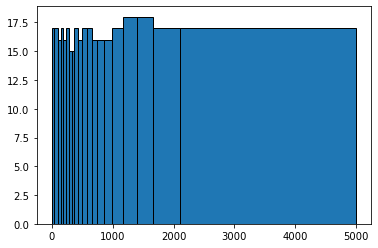

In [111]:
import matplotlib.pyplot as plt

test = yf.loc[yf['vital_status'] == 1]

plt.hist(test['time'], bins=[0,40,98,153,180,240,280,330,370,428,495,580,660,750,860,990,1170,1400,1660,2100,5000],ec='black')
#plt.hist(ytime, bins=range(0,7100,50),ec='black',color='orange')
#[0,55,100,135,180,240,260,322,370,430,455,520,580,620,730,840,970,1140,1350,1590,1900,2540,9200]

><p> Here we set our time intervals and create the survival matrix used by the nnet-survival model </p>

In [113]:
#breaks=np.asarray([0,55,100,135,180,240,260,322,370,430,455,520,580,620,730,840,970,1140,1350,1590,1900,2540,9200])
breaks=np.asarray([0,40,98,153,180,240,280,330,370,428,495,580,660,750,860,990,1170,1400,1660,2100,5000])
n_intervals = len(breaks) - 1
timegap = breaks[1:] - breaks[:-1]

In [114]:
print(n_intervals)

20


In [115]:
import nnet_survival

yf = nnet_survival.make_surv_array(ytime, ystatus, breaks)


><p> This step adds the status and quantile labels to our survival matrix <br>
This is used only with our 5-fold CV hyperparameter optimization</p>

In [116]:
yf_final = ([],[])

for matrix,status,quantile in zip(yf,ystatus,yquantile):
    yf_final[0].append(matrix)
    status_quantile = (str(int(status)) + "_" + str(quantile))
    yf_final[1].append(status_quantile)




## Custom class for hypermodel + concordance index function
<p> This are 2 custom classes, one being a hypermodel that is built by our hyperparameter tuner, and where you can add variable parameters which will be tested. <br>
The other is a custom hyper parameter tuner that utilizes cross validation.</p>

In [87]:
from keras_tuner import HyperModel
from tensorflow.keras.metrics import Metric
import tensorflow.keras.backend as K
import keras_tuner


class SurvivalHyperModel(HyperModel):
    def __init__(self, n_intervals, weights=[]):
        self.n_intervals = n_intervals
        self.weights = weights
    def build(self, hp):
        model = Sequential()
        hp_l2_value = hp.Choice('l2_value', values=[0.01,0.001,0.0001,0.00001])
        model.add(Dense(np.sqrt(xf.shape[1]), input_dim=xf.shape[1], bias_initializer='zeros',activation='relu', kernel_regularizer=regularizers.l2(hp_l2_value)))
        # model.add(Dense(np.sqrt(xf.shape[1]), input_dim=xf.shape[1], bias_initializer='zeros',activation='relu'))
        #hp_dropout_rate_1 = hp.Choice('dropout_rate1', values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
        #model.add(Dropout(0.9))
        model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
        model.add(nnet_survival.PropHazards(self.n_intervals))
        #hp_learning_rate = hp.Choice('learning_rate1', values=[0.00001,0.0001,0.001])
        model.compile(loss=nnet_survival.surv_likelihood(self.n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001),run_eagerly=False)
        if self.weights:
            model.layers[0].set_weights(self.weights)
            return model
        else:
            return model
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(*args,
                         shuffle=False,
                         **kwargs,
                        )
    

class CVTuner(keras_tuner.engine.tuner.Tuner):
    def run_trial(self, trial, x, y,epochs=1, *args, **kwargs):
        skf = StratifiedKFold(n_splits=5, shuffle=False)
        skf.get_n_splits(x,y[1])
        val_losses = []
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[8,16])
        fold = 1
        hp = trial.hyperparameters
        for train_indices, test_indices in skf.split(x,y[1]):
            early_stopping_hp = EarlyStopping(monitor='val_loss', patience=(100),min_delta=0.0005, restore_best_weights=True)
            dir_for_logs = ("Logs/ktuner/logs_pdac_21/" + str(trial.trial_id) + "/fold_" + str(fold))
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_for_logs, histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
            callbacks_list = [early_stopping_hp,tensorboard_callback]
            x_train, x_test = x[train_indices], x[test_indices]
            y_train, y_test = np.array(y[0])[train_indices], np.array(y[0])[test_indices]
            y_train_labels, y_test_labels = np.array(y[1])[train_indices], np.array(y[1])[test_indices]
            model = self.hypermodel.build(hp)
            model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=kwargs['batch_size'], epochs=epochs, callbacks=callbacks_list, verbose=0)
            #model.fit(x_train, y_train,validation_data=(x_test,y_test), batch_size=8, epochs=epochs, callbacks=callbacks_list, verbose=0)            
            y_pred = model.predict(x_test, verbose=0)
            surv_prob=np.cumprod(y_pred, axis=1)[:,-1]
            val_losses.append(model.evaluate(x_test, y_test))
            fold += 1
        self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
        #self.save_model(trial.trial_id, model)

    

### Hyperparameter optimization and training of the multi-cancer model

<p> In this section of code the hyperparameter tuning of the multi-cancer model occurs. <br>
    The Hyperparameters are tuned on the whole datasets, and the results can be viewed with tensorboard. </p>

In [ ]:
importlib.reload(nnet_survival)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

scaler = MinMaxScaler()
xf_t = scaler.fit_transform(xf)

### logfile - Filename in which the results will be stored of the hyperparameter tuning.
###           Call this file with Tensorboard to view loss curves and hyperparameter tuning results.
###
### name_of_project - Name of the Keras Tuner project.
###                   Make sure this is different if you want to try a new search, else it will 
###                   just give you the results of the project previous project that had the same name
###
### name_of_dir - Directory where projects will be stored.

logfile = "Logs/ktuner/logs_pretrain_9_5/"
name_of_project = "pretrain_model_9_5"
name_of_dir = "pretrain_model_dir"
                                                
tuner = CVTuner(
    hypermodel=SurvivalHyperModel(n_intervals),
    project_name=name_of_project,
    directory=name_of_dir,
    logger = TensorBoardLogger(metrics=["val_loss"], logdir=logfile),
    oracle=kt.oracles.BayesianOptimization(
        objective='val_loss',
        max_trials=10))
tuner.search(xf_t,yf_final,epochs=40000,verbose=1)




><p> Now the model is ran using the optimal parameters found in the previous step </p>

In [117]:
importlib.reload(nnet_survival)

optimal_l2 = 0.01
optimal_batch = 16

scaler = MinMaxScaler()
xf_t = scaler.fit_transform(xf)


yf = np.array(yf_final[0])


optimal_model = Sequential()
optimal_model.add(Dense(np.sqrt(xf.shape[1]), input_dim=xf.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
optimal_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
optimal_model.add(nnet_survival.PropHazards(n_intervals))
opt = optimizers.Adam(learning_rate=0.00001)
optimal_model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=opt)


#early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.001, restore_best_weights=True)
dir_for_log = ("Logs/ktuner/logs_pretrain_subset")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_for_log, histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
callbacks_list = [tensorboard_callback]

history = optimal_model.fit(xf_t,yf,batch_size=optimal_batch,epochs=1200, callbacks=callbacks_list,verbose=0)

optimal_model.save_weights("Weights/CoxTnnet_pretrain_weights_subset")   

# print("Performance model on full dataset (very optimistic):")
y_pred = optimal_model.predict(xf_t, verbose=0)
oneyr_surv = np.cumprod(y_pred[:, 0:np.nonzero(breaks > 365)[0][0]], axis=1)[:, -1]
c_index_test = concordance_index(ytime, oneyr_surv, ystatus)
print("C_index: " + str(c_index_test))


2022-12-06 10:22:09.975449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 10:22:10.080107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 10:22:10.081072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 10:22:10.095991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

C_index: 0.9803412159397757



### Data preperation TCGA PDAC
<p> Same steps as for the multi-cancer data.<br>
    Make sure there similar amounts of death events per time interval. </p>

In [154]:
xt = xt.to_numpy()
#
ytime = yt['time'].to_numpy()
ystatus = yt['vital_status'].to_numpy()
ystatusbool = yt['vital_status'].astype(np.bool).to_numpy()


(array([15., 14., 15., 15., 14., 13., 14., 14., 14., 15.]),
 array([   0,   17,   70,  130,  180,  230,  300,  400,  580,  730, 2200]),
 <BarContainer object of 10 artists>)

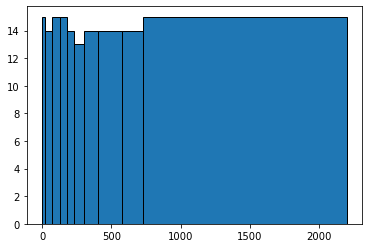

In [119]:
import matplotlib.pyplot as plt

test = yt.loc[yt['vital_status'] == 1]

#20 time intervals
#plt.hist(test['time'], bins=[0,100,120,125,130,150,217,240,280,280,380,460,475,486,565,605,650,690,730,1300,2200],ec='black')
#10 time intervals
#plt.hist(yt['time'], bins=[0,110,130,190,250,310,475,550,650,730,2200],ec='black')
plt.hist(yt['time'], bins=[0,17,70,130,180,230,300,400,580,730,2200],ec='black')

In [155]:
breaks=np.array([0,110,130,190,250,310,475,550,650,730,2200])
n_intervals = len(breaks) - 1
timegap = breaks[1:] - breaks[:-1]

In [ ]:
print(n_intervals)

10


In [156]:
y_t = nnet_survival.make_surv_array(ytime, ystatus, breaks)

In [157]:
first_quantile = np.quantile(ytime,0.25)
second_quantile = np.quantile(ytime,0.5)
third_quantile = np.quantile(ytime,0.75)

print(first_quantile)
print(second_quantile)
print(third_quantile)

110.0
228.0
482.5


In [158]:
yquantile = []
for time in ytime:
    if time >= 0 and time < first_quantile:
        yquantile.append(1)
    elif time >= first_quantile and time < second_quantile:
        yquantile.append(2)
    elif time >= second_quantile and time < third_quantile:
        yquantile.append(3)
    elif time >= third_quantile:
        yquantile.append(4)


In [159]:
yt_final = ([],[])

for matrix,status,quantile in zip(y_t,ystatus,yquantile):
    yt_final[0].append(matrix)
    status_quantile = (str(int(status)) + "_" + str(quantile))
    yt_final[1].append(status_quantile)

### Data preperation ICGC 
<p> Same steps as TCGA data, again make sure there are similar amounts of death events per time interval. </p>


In [160]:
xv = xv.to_numpy()

yvtime = yv['time'].to_numpy()
yvstatus = yv['donor_vital_status'].to_numpy()




In [ ]:
import matplotlib.pyplot as plt

test = yv.loc[yv['donor_vital_status'] == 1]

plt.hist(test['time'], bins=[0,165,230,260,345,390,425,460,600,1100,1880],ec='black')

In [ ]:
vbreaks = np.array([0,165,230,260,345,390,425,460,600,1100,1880])

In [161]:
y_v = nnet_survival.make_surv_array(yvtime, yvstatus, vbreaks)

In [162]:
first_quantile_v = np.quantile(yvtime,0.25)
second_quantile_v = np.quantile(yvtime,0.5)
third_quantile_v = np.quantile(yvtime,0.75)

print(first_quantile_v)
print(second_quantile_v)
print(third_quantile_v)

255.5
413.5
719.5


In [163]:
yvquantile = []
for time in yvtime:
    if time >= 0 and time < first_quantile_v:
        yvquantile.append(1)
    elif time >= first_quantile_v and time < second_quantile_v:
        yvquantile.append(2)
    elif time >= second_quantile_v and time < third_quantile_v:
        yvquantile.append(3)
    elif time >= third_quantile_v:
        yvquantile.append(4)

In [164]:
yv_final = ([],[])

for matrix,status,quantile in zip(y_v,yvstatus,yvquantile):
    yv_final[0].append(matrix)
    status_quantile = (str(int(status)) + "_" + str(quantile))
    yv_final[1].append(status_quantile)

### Custom C-index class
<p> This class can be passed as a callback which will calculate the C-index for train/validation data during training. </p>

In [26]:
class cindex(tf.keras.callbacks.Callback):

    def __init__(self, train, validation=None):
        super(cindex, self).__init__()
        self.validation = validation
        self.train = train
        
    def on_epoch_end(self, epoch, logs={}):
        logs['cindex_score_train'] = float('-inf')
        x_train, y_train, ytime_train, ystatus_train = self.train[0], self.train[1], self.train[2], self.train[3]
        y_pred = nnet_survival.nnet_pred_surv(model.predict(x_train,verbose=0), breaks, 365)
        score = concordance_index(ytime_train, y_pred, ystatus_train)
        
        if (self.validation):
            logs['cindex_score_val'] = float('-inf')
            x_val, y_val, y_time_val, ystatus_val  = self.validation[0], self.validation[1], self.validation[2], self.validation[3]
            y_pred = nnet_survival.nnet_pred_surv(model.predict(x_val,verbose=0), breaks, 365)
            val_score = concordance_index(ytime_val, y_pred, ystatus_val)
            logs['cindex_score_train'] = score
            logs['cindex_score_val'] = val_score
        else:
            logs['cindex_score_train'] = score
    

### Run TCGA PDAC model just once and store weights

In [101]:
importlib.reload(nnet_survival)

### DATA SCALING
scaler = MinMaxScaler()
xt_t = scaler.fit_transform(xt)

### SET PARAMETERS
optimal_l2 = 0.00001
optimal_batch = 8

### CREATE MODEL
model = Sequential()
model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
model.add(nnet_survival.PropHazards(n_intervals))
model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

### TENSORBOARD CALLBACK FOR LOGS
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_once_notransfer"), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
callbacks_list = [tensorboard_callback]

### FIT MODEL ON FULL PDAC DATASET
history = model.fit(xt_t,y_t,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0) 

### SAVE MODEL WEIGHTS
model.save_weights("Weights_all/CoxTnnet_pdac_notransfer")  

### Run TCGA PDAC Model with transferred weights from Multi-Cancer Model

In [133]:
importlib.reload(nnet_survival)

### DATA SCALING
scaler = MinMaxScaler()
xt_t = scaler.fit_transform(xt)

### SET PARAMETERS
optimal_l2 = 0.00001
optimal_batch = 8

### CREATE MODEL TO INITIALIZE WEIGHTS INTO
init_model = Sequential()
init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
init_model.add(nnet_survival.PropHazards(20))
init_model.compile(loss=nnet_survival.surv_likelihood(20), optimizer=optimizers.Adam(learning_rate=0.00001))

### LOAD WEIGHTS FROM MULTI-CANCER MODEL
init_model.load_weights("Weights_all/CoxTnnet_pretrain_weights_subset")


### CREATE MODEL FOR FINE-TUNING
model = Sequential()
model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
model.add(nnet_survival.PropHazards(n_intervals))
model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

### TRANSFER WEIGHTS OF MULTI-CANCER MODEL
model.layers[0].set_weights(init_model.layers[0].get_weights())

### TENSORBOARD CALLBACK FOR LOGS
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_subset"), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
callbacks_list = [tensorboard_callback]

### FIT MODEL
history = model.fit(xt_t,y_t,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0) 

### SAVE MODEL WEIGHTS
model.save_weights("Weights_all/CoxTnnet_pdac_subset")  

### Train ICGC PDAC and validate with 5-fold CV

In [166]:
importlib.reload(nnet_survival)

### Set transfer_learning to True, if you want transfer learning, else set it too false
transfer_learning = False

### File which will store the C-indexes obtained
results_file = "Results/cindexes_icgc_exp1_nopdac"

cindex_list = []
cindex_train_list = []

total_cindexes = []
total_cindexes_train = []

### Set optimal parameters found with hyperparameter tuning
optimal_l2 = 0.00001
optimal_batch = 8

if transfer_learning == True:
    ### CREATE MODEL TO INITIALIZE WEIGHTS INTO ###
    
    init_model = Sequential()
    init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
    init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    init_model.add(nnet_survival.PropHazards(10))
    init_model.compile(loss=nnet_survival.surv_likelihood(10), optimizer=optimizers.Adam(learning_rate=0.000001))

    ### LOAD WEIGHTS YOU WANT INTO MODEL ###

    init_model.load_weights("Weights_all/CoxTnnet_pdac_subset")

### Create Repeated Stratified Kfold cross validation object

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=24)

k = 1

test_performance = []
train_performance = []

### ENTER REPEATED 5 FOLD CV
for train_indices, test_indices in rskf.split(xv,yv_final[1]):
    print("fold: " + str(k) + "/50")
    
    ### MAKE SPLITS ###
    x_train, x_test = xv[train_indices], xv[test_indices]
    y_train, y_test = np.array(yv_final[0])[train_indices], np.array(yv_final[0])[test_indices]
    y_train_labels, y_test_labels = np.array(yv_final[1])[train_indices], np.array(yv_final[1])[test_indices]
    ystatus_train, ystatus_test = yvstatus[train_indices], yvstatus[test_indices]
    ytime_train, ytime_test = yvtime[train_indices], yvtime[test_indices]

    ## SCALE TRAIN AND TEST DATA ###
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    ### CREATE MODEL TO TRAIN WITH ###
    model = Sequential()
    model.add(Dense(np.sqrt(xv.shape[1]), input_dim=xv.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
    model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    model.add(nnet_survival.PropHazards(n_intervals))
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

    
    if transfer_learning == True:
        ### TRANSFER WEIGHTS TO MODEL TO TRAIN ###
        model.layers[0].set_weights(init_model.layers[0].get_weights())

    ### TENSORBOARD CALLBACK ###
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_icgc_exp1_nopdac/fold_" + str(k)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
    callbacks_list = [tensorboard_callback]

    ### TRAIN MODEL
    history = model.fit(x_train_scaled,y_train,batch_size=optimal_batch,epochs=2600, callbacks=callbacks_list,verbose=0)


    ### PREDICTIONS ON TRAIN AND TEST SET ###
    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_train_scaled,verbose=0), breaks, 365)
    c_index_train = concordance_index(ytime_train, y_pred, ystatus_train)

    y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test_scaled,verbose=0), breaks, 365)
    c_index_test = concordance_index(ytime_test, y_pred, ystatus_test)

    train_performance.append(c_index_train)
    test_performance.append(c_index_test)

    total_cindexes.append(c_index_test)
    total_cindexes_train.append(c_index_train)

    ### SAVE RESULTS ###
    with open(results_file, 'a') as o:
        print("Fold: " + str(k) + "\n",file=o)
        print("C-index train set: " + str(c_index_train), file=o)
        print("C-index test set: " + str(c_index_test), file=o)
        o.close()

    k += 1

with open(results_file, 'a') as o:
    print("\n",file=o)
    print("Average C-index train total: " + str(sum(total_cindexes_train) / 50),file=o)
    print("Average C-index test total: " + str(sum(total_cindexes) / 50),file=o) 
    print(str(total_cindexes),file=o)
    print(str(total_cindexes_train),file=o)
    o.close()    

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 1/50
fold: 2/50
fold: 3/50
fold: 4/50
fold: 5/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 6/50
fold: 7/50
fold: 8/50
fold: 9/50
fold: 10/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 11/50
fold: 12/50
fold: 13/50
fold: 14/50
fold: 15/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 16/50
fold: 17/50
fold: 18/50
fold: 19/50
fold: 20/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 21/50
fold: 22/50
fold: 23/50
fold: 24/50
fold: 25/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 26/50
fold: 27/50
fold: 28/50
fold: 29/50
fold: 30/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 31/50
fold: 32/50
fold: 33/50
fold: 34/50
fold: 35/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 36/50
fold: 37/50
fold: 38/50
fold: 39/50
fold: 40/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 41/50
fold: 42/50
fold: 43/50
fold: 44/50
fold: 45/50


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


fold: 46/50
fold: 47/50
fold: 48/50
fold: 49/50
fold: 50/50


#### Train the model

In [32]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from tensorflow import keras
from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)
import tensorflow.keras.backend as K
import importlib
importlib.reload(nnet_survival)

cindex_list = []
cindex_train_list = []
maxcindex = 0

#x_train_first, x_test, y_train_first, y_test, y_train_labels_first, y_test_labels, ytime_train_first, ytime_test, ystatus_train_first, ystatus_test, ystatus_time_train_first, ystatus_time_test = train_test_split(xt,yt_final[0],yt_final[1],ytime,ystatus,ystatus_time,test_size=0.15,stratify=yt_final[1])
  
#y_train_final = ([],[])

#for matrix,status_quantile in zip(y_train_first,y_train_labels_first):
#    y_train_final[0].append(matrix)
#    y_train_final[1].append(status_quantile)

# init_model = Sequential()
# init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu'))
# #init_model.add(Dropout(0.9))
# init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
# init_model.add(nnet_survival.PropHazards(22))
# init_model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001))

# init_model.load_weights("Weights_all/CoxTnnet_pretrain_weights_all_7")


# tuner = CVTuner(
#     hypermodel=SurvivalHyperModel(n_intervals,init_model.layers[0].get_weights()),
#     project_name='pdac_model_21',
#     directory='pdac_model_dir',
#     logger=TensorBoardLogger(metrics=["val_loss"], logdir=("ktuner/logs_pdac_21/")),
#     oracle=kt.oracles.RandomSearch(
#         objective='val_loss',
#         max_trials=8))
# tuner.search(xt,yt_final,epochs=40000)

# tuner.results_summary(num_trials=8)

optimal_l2 = 0.00001
optimal_batch = 8


#     init_model = Sequential()
#     init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
#     init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
#     init_model.add(nnet_survival.PropHazards(22))
#     init_model.compile(loss=nnet_survival.surv_likelihood(22), optimizer=optimizers.Adam(learning_rate=0.00001))

#     init_model.load_weights("Weights_all/CoxTnnet_pretrain_weights_all_8")

    model = Sequential()
    model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
    #model.add(Dropout(optimal_dropout_1))
    model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    model.add(nnet_survival.PropHazards(n_intervals))
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

#    model.layers[0].set_weights(init_model.layers[0].get_weights())
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_final_icgc_nt_5/outer_loop_" + str(p + 1)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
    callbacks_list = [tensorboard_callback]

    history = model.fit(xt,y_t,batch_size=optimal_batch,epochs=4800, callbacks=callbacks_list,verbose=0) 




for p in range(10):
    print("Outer loop: " + str(p + 1))
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    k = 1
    
    test_performance = []
    train_performance = []
    
#     init_model = Sequential()
#     init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros', activation='relu',kernel_regularizer=regularizers.l2(0.01)))
#     init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
#     init_model.add(nnet_survival.PropHazards(22))
#     init_model.compile(loss=nnet_survival.surv_likelihood(22), optimizer=optimizers.Adam(learning_rate=0.00001))

#     init_model.load_weights("Weights_all/CoxTnnet_pretrain_weights_all_8")

    model = Sequential()
    model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
    #model.add(Dropout(optimal_dropout_1))
    model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
    model.add(nnet_survival.PropHazards(n_intervals))
    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.000001))

#    model.layers[0].set_weights(init_model.layers[0].get_weights())
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_final_icgc_nt_5/outer_loop_" + str(p + 1)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
    callbacks_list = [tensorboard_callback]

    history = model.fit(xt,y_t,batch_size=optimal_batch,epochs=4800, callbacks=callbacks_list,verbose=0)  
    
    
#     for train_indices, test_indices in skf.split(xt,yt_final[1]):
#         print("Inner loop: " + str(k))
#         x_train, x_test = xt[train_indices], xt[test_indices]
#         y_train, y_test = np.array(yt_final[0])[train_indices], np.array(yt_final[0])[test_indices]
#         y_train, y_test_labels = np.array(yt_final[1])[train_indices], np.array(yt_final[1])[test_indices]
#         ystatus_train, ystatus_test = ystatus[train_indices], ystatus[test_indices]
#         ytime_train, ytime_test = ytime[train_indices], ytime[test_indices]
        
#         # x_train, x_val, y_train, y_val, y_train_labels, y_val_labels, ytime_train, ytime_val, ystatus_train, ystatus_val, = train_test_split(x_train_first,y_train_first,
#         #                                                                                                                                      y_train_labels_first,
#         #                                                                                                                                      ytime_train_first,
#         #                                                                                                                                      ystatus_train_first,
#         #                                                                                                                                      test_size=0.15,
#         #                                                                                                                                      stratify=y_train_labels_first,
#         #                                                                                                                                      random_state=(419))
        
        
#         init_model = Sequential()
#         init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.01)))
#         init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
#         init_model.add(nnet_survival.PropHazards(22))
#         init_model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001))

#         init_model.load_weights("Weights_all/CoxTnnet_pretrain_weights_all_7")

#         model = Sequential()
#         model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(optimal_l2)))
#         #model.add(Dropout(optimal_dropout_1))
#         model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
#         model.add(nnet_survival.PropHazards(n_intervals))
#         model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001))

# #        model.layers[0].set_weights(init_model.layers[0].get_weights())
        
        
#         #early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.001, restore_best_weights=True)
#         tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_final_exp30/outer_loop_" + str(p + 1) + "/fold_" + str(k)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
#         #cindex_callback = cindex(train=(x_train,y_train,ytime_train,ystatus_train),validation=(x_val,y_val,ytime_val,ystatus_val))
#         callbacks_list = [tensorboard_callback]
        
#         history = model.fit(x_train_first,y_train_first,batch_size=optimal_batch,epochs=120, callbacks=callbacks_list,verbose=0)
        
# #         train_summary_writer = tf.summary.create_file_writer("ktuner/logs_pdac_final_exp28/outer_loop_" + str(p + 1) + "/fold_" + str(k))
# #         for epoch in range(len(history.history['cindex_score_train'])):
# #             with train_summary_writer.as_default():
# #                 tf.summary.scalar('cindex_score_train', history.history['cindex_score_train'][epoch], step=epoch)
# #                 tf.summary.scalar('cindex_score_val', history.history['cindex_score_val'][epoch], step=epoch)
        
#         k += 1
        
#         y_pred = nnet_survival.nnet_pred_surv(model.predict(x_train,verbose=0), breaks, 365)
#         c_index_train = concordance_index(ytime_train, y_pred, ystatus_train)

#         y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test,verbose=0), breaks, 365)
#         c_index_test = concordance_index(ytime_test, y_pred, ystatus_test)
        
#         train_performance.append(c_index_train)
#         test_performance.append(c_index_test)

#         # if c_index_test > maxcindex:
#         #     maxcindex = c_index_test
#         #     model.save("CoxTnnet_PDAC_model_1.0")
    
    y_pred_t = nnet_survival.nnet_pred_surv(model.predict(xt,verbose=0), breaks, 365)
    c_index_train = concordance_index(ytime, y_pred_t, ystatus)

    y_pred_v = nnet_survival.nnet_pred_surv(model.predict(xv_t,verbose=0), vbreaks, 365)
    print(y_pred_v)
    c_index_test = concordance_index(yvtime, y_pred_v, yvstatus)
    
    print("Train performance:")
    print("C_index: " + str(c_index_train))
    
    print("Test performance:")
    print("C_index: " + str(c_index_test))
    
    cindex_train_list.append(c_index_train)
    cindex_list.append(c_index_test)
        
        
    
    
    
    



# #     x_train_first, x_test, y_train_first, y_test, y_train_labels_first, y_test_labels, ytime_train_first, ytime_test, ystatus_train_first, ystatus_test, ystatus_time_train_first, ystatus_time_test = train_test_split(xt,yt_final[0],yt_final[1],ytime,
# #                                                                                                                                                ystatus,ystatus_time,
# #                                                                                                                                                test_size=0.15,
# #                                                                                                                                                stratify=yt_final[1],
# #                                                                                                                                                random_state=(560+p))
    

    
# #     y_train = np.array(y_train)
# #     y_val = np.array(y_val)
# #     y_test = np.array(y_test)
    
# #     init_model = Sequential()
# #     init_model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu'))
# #     #init_model.add(Dropout(0.9))
# #     init_model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
# #     init_model.add(nnet_survival.PropHazards(22))
# #     init_model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001))

# #     init_model.load_weights("Weights_all/CoxTnnet_pretrain_weights_all_6")
    
# #     model = Sequential()
# #     model.add(Dense(np.sqrt(xt.shape[1]), input_dim=xt.shape[1], bias_initializer='zeros',activation='relu',kernel_regularizer=regularizers.l2(0.001)))
# #     #model.add(Dropout(optimal_dropout_1))
# #     model.add(Dense(1, use_bias=0, kernel_initializer='zeros'))
# #     model.add(nnet_survival.PropHazards(n_intervals))
# #     model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizers.Adam(learning_rate=0.00001))
    
# #     model.layers[0].set_weights(init_model.layers[0].get_weights())

# #     early_stopping = EarlyStopping(monitor='val_loss', patience=100, min_delta=0.001, restore_best_weights=True)
# #     tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=("ktuner/logs_pdac_final_exp25/outer_loop_" + str(p + 1)), histogram_freq=0, embeddings_freq=0, write_graph=False, update_freq='batch')
# #     cindex_callback = cindex(train=(x_train,y_train,ytime_train,ystatus_train),validation=(x_val,y_val,ytime_val,ystatus_val))
# #     callbacks_list = [early_stopping,tensorboard_callback,cindex_callback]

# #     history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=optimal_batch,epochs=40000, callbacks=callbacks_list,verbose=0)
    
# #     train_summary_writer = tf.summary.create_file_writer("ktuner/logs_pdac_final_exp25/outer_loop_" + str(p + 1))
    
# #     for epoch in range(len(history.history['cindex_score_train'])):
# #         with train_summary_writer.as_default():
# #             tf.summary.scalar('cindex_score_train', history.history['cindex_score_train'][epoch], step=epoch)
# #             tf.summary.scalar('cindex_score_val', history.history['cindex_score_val'][epoch], step=epoch)
            
    
# #     outputs = [K.function([model.input], [layer.output])([x_train_first]) for layer in model.layers]

# #     i = 1
# #     for output in outputs:
# #         print("Output layer: " + str(i))
# #         print(output[0][0])
# #         print(output[0][1])
# #         i += 1
            

#     # Performance of final model
  
# #     y_pred = nnet_survival.nnet_pred_surv(model.predict(x_train_first,verbose=0), breaks, 365)
# #     c_index_train = concordance_index(ytime_train_first, y_pred, ystatus_train_first)
    
# #     print("Train performance:")
# #     print("C_index: " + str(c_index_train))
    
# #     y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test,verbose=0), breaks, 365)
# #     c_index_test = concordance_index(ytime_test, y_pred, ystatus_test)

# #     print("Test performance:")
# #     print("C_index: " + str(c_index_test))

# #     cindex_train_list.append(c_index_train)
# #     cindex_list.append(c_index_test)

# #     if c_index_test > maxcindex:
# #         maxcindex = c_index_test
# #         model.save("CoxTnnet_PDAC_model_1.0")

# with open('cscore_pdacmodel.txt', 'a') as o:
#         print(str(cindex_train_list) + "\n", file=o)
#         print(str(cindex_list) + "\n", file=o)
#         print("Average C-inde32x: " + str(sum(cindex_list) / 10) + "\n",file=o)
#         o.close()
print(cindex_train_list)
print(cindex_list)
print("Average C-index train: " + str(sum(cindex_train_list)/10))
print("Average C-index: " + str(sum(cindex_list)/10))

Outer loop: 1
[0.81276486 0.83473551 0.85889699 0.85044647 0.85432703 0.86304145
 0.87062065 0.85519214 0.84702138 0.73250706 0.84808681 0.82784076
 0.85411206 0.82849777 0.83571908 0.8647281  0.84309663 0.86115331
 0.85656239 0.85227628 0.79159747 0.78321909 0.81801234 0.77941311
 0.63489613 0.85335067 0.81976298 0.85195978 0.83693124 0.78845679
 0.74468658 0.84296907 0.82616456 0.85510292 0.80675087 0.81784977
 0.77356359 0.81807988 0.81645269 0.84496958 0.84770481 0.79191675
 0.84443816 0.84807843 0.85171938 0.84169977 0.7911203  0.36691186
 0.80461307 0.79595892 0.78354391 0.84347019 0.82952772 0.8134797
 0.83376559 0.8383272  0.84027645 0.8094311  0.8536948  0.75089033
 0.81719008 0.8279066  0.78258366 0.83690281 0.24888171 0.66387479
 0.82109033 0.82566437 0.7813409  0.82903195 0.78786297 0.7012218 ]
Train performance:
C_index: 0.6507627393703344
Test performance:
C_index: 0.5350678733031674
Outer loop: 2
[0.81901428 0.83883169 0.86415346 0.85660712 0.85888307 0.86689772
 0.87455

In [264]:
print(cindex_train_list)
print(cindex_list)
print("Average C-index: " + str(sum(cindex_list)/10))

[0.8818565400843882, 0.8799091204154496, 0.8906199285946121, 0.8834793898085037, 0.8834793898085037, 0.8847776695877961, 0.8876987990912042, 0.881207400194742, 0.8795845504706264, 0.8763388510223953]
[0.5542986425339367, 0.5537330316742082, 0.5574095022624435, 0.5605203619909502, 0.5390271493212669, 0.5537330316742082, 0.5588235294117647, 0.5559954751131222, 0.544683257918552, 0.5565610859728507]
Average C-index: 0.5534785067873302


[0.597577   0.54724316 0.59739087 0.5033036  0.5304236  0.55372898
 0.48690771 0.59559546 0.60540265 0.634495   0.626451   0.55588039
 0.65917277 0.57541329 0.5516417  0.62380797 0.66145209 0.51232759
 0.56335759 0.40504964 0.64507    0.6105624 ]
[ 160.  347.  910.   95.  488.   35.  460. 1332.  397.   23.  161.  128.
    7.  627.  738.  164.  105.    7.  532.  145.  329.  239.]
[0 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1]


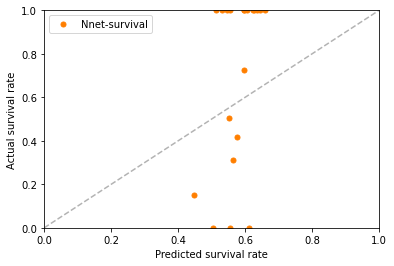

In [80]:

#loaded_model = tf.keras.models.load_model("CoxTnnet_PDAC_model_1.0",custom_objects={'loss': nnet_survival.surv_likelihood(n_intervals)})


x_train, x_test, y_train, y_test, ytime_train, ytime_test, ystatus_train, ystatus_test, = train_test_split(xt,yt_final[0],
                                                                                                           ytime,
                                                                                                           ystatus,
                                                                                                           test_size=0.15,
                                                                                                           stratify=yt_final[1],
                                                                                                           random_state=(419+k))


y_pred = nnet_survival.nnet_pred_surv(model.predict(x_test,verbose=0), breaks, 365)
print(y_pred)
print(ytime_test)
print(ystatus_test)

n_bins = 20
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
my_alpha = 1
my_markersize = 5.

plt.plot([0,1], [0,1], ls="--", c=".7")
pred, actual=calib_plot(365, n_bins, y_pred, ytime_test, ystatus_test,
                          CB_color_cycle[1],'Nnet-survival', alpha=my_alpha, markersize=my_markersize, markertype='o')

plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.xlabel('Predicted survival rate')
plt.ylabel('Actual survival rate')

plt.show()
        
  






In [ ]:
with open('cscore_pdacmodel_all_adaptive_exp1.txt', 'a') as o:
        print(str(cindex_train_list), file=o)
        print(str(cindex_list), file=o)
        #print(str(cipcw_list), file=o)
        print("Average C-index: " + str(sum(cindex_list) / 10),file=o)
        #print("Average C-ipcw: " + str(sum(cipcw_list) / 10),file=o)
        o.close()

In [32]:
print("Average C-index test: " + str(sum(cindex_list)/10))
print("Average C-index train: " + str(sum(cindex_train_list)/10))

Average C-index test: 0.6406241703369638
Average C-index train: 0.7917996927485694


In [33]:
print(np.median(cindex_list))

0.6752482105749249


In [ ]:
print("Average Brier score: " + str(sum(brierscore_list)/10))